In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pendulum

df = pd.read_csv('energy_data_oak.csv')

buffer_start_cols = [col for col in df.columns if col.startswith('buffer') and col.endswith('start')]
df['average_buffer_temp_start'] = df[buffer_start_cols].apply(lambda x: x.mean(), axis=1)
storage_start_cols = [col for col in df.columns if col.startswith('tank') and col.endswith('start')]
df['average_store_temp_start'] = df[storage_start_cols].apply(lambda x: x.mean(), axis=1)
df = df.drop(columns=buffer_start_cols + storage_start_cols)

df['hour_start_dt'] = pd.to_datetime(df['hour_start'])
dates_temp = [pendulum.datetime(x.year, x.month, x.day, x.hour, x.minute, tz='America/New_York') for x in df['hour_start_dt']]
df['hour_start_s'] = [int(x.timestamp()) for x in dates_temp]

df_shifted = df.shift(-1)
one_hour_mask = (df_shifted['hour_start_dt'] - df['hour_start_dt']).dt.total_seconds() == 3600
df['average_buffer_temp_end'] = pd.Series(index=df.index)
df.loc[one_hour_mask, 'average_buffer_temp_end'] = df_shifted.loc[one_hour_mask, 'average_buffer_temp_start']

df['buffer_change_kwh'] = 120*3.79*4.187/3600*(df['average_buffer_temp_end']-df['average_buffer_temp_start'])*5/9

df['average_store_temp_end'] = pd.Series(index=df.index)
df.loc[one_hour_mask, 'average_store_temp_end'] = df_shifted.loc[one_hour_mask, 'average_store_temp_start']

df['storage_change_kwh'] = 3*120*3.79*4.187/3600*(df['average_store_temp_end']-df['average_store_temp_start'])*5/9

df['average_store_temp_start'] = df['average_store_temp_start'].round(1)
df['average_buffer_temp_start'] = df['average_buffer_temp_start'].round(1)


df['implied_heat_load'] = df['hp_kwh_th'] - df['store_change_kwh'] - df['buffer_change_kwh']
df['implied_heat_load2'] = df['hp_kwh_th'] - df['storage_change_kwh'] - df['buffer_change_kwh']
# display(df[['store_change_kwh', 'storage_change_kwh']][:50])

# Find all rows with the same storage and buffer start as the first row
target_store_temp = list(df['average_store_temp_start'])[0]
target_buffer_temp = list(df['average_buffer_temp_start'])[0]
filtered = df[
    (df['average_store_temp_start'] >= target_store_temp - 1) &
    (df['average_store_temp_start'] <= target_store_temp + 1) &
    (df['average_buffer_temp_start'] >= target_buffer_temp - 1) &
    (df['average_buffer_temp_start'] <= target_buffer_temp + 1)
]
display(filtered)

,hour_start,hp_kwh_el,hp_kwh_th,dist_kwh,store_change_kwh,hp_avg_lwt,hp_avg_ewt,dist_avg_swt,dist_avg_rwt,relay_3_pulled_fraction,...,average_buffer_temp_start,average_store_temp_start,hour_start_dt,hour_start_s,average_buffer_temp_end,buffer_change_kwh,average_store_temp_end,storage_change_kwh,implied_heat_load,implied_heat_load2
0,2025-01-01 00:00:44,0.80,1.16,2.73,0.00,90.5,87.8,128.7,96.2,0.00,...,121.1,142.9,2025-01-01 00:00:44,1735707600,113.475,-2.248070,142.091667,-0.727317,3.408070,4.135387
2,2025-01-01 02:00:44,0.15,0.00,3.03,0.00,101.0,97.3,127.2,102.4,0.00,...,120.4,143.7,2025-01-01 02:00:44,1735714800,112.600,-2.292150,142.966667,-0.675890,2.292150,2.968040
1269,2025-02-23 05:00:44,7.73,13.87,5.30,3.24,125.2,110.3,131.1,102.4,0.15,...,121.3,143.5,2025-02-23 05:00:44,1740304800,133.700,3.643931,146.008333,2.211337,6.986069,8.014732
1600,2025-03-09 00:00:44,10.43,19.29,5.81,9.62,146.4,124.0,131.3,105.3,0.53,...,121.8,143.3,2025-03-09 00:00:44,1741496400,131.000,2.710908,153.150000,8.676375,6.959092,7.902717
1861,2025-03-19 22:00:44,0.19,0.00,0.58,0.00,83.2,80.1,123.0,62.3,0.00,...,121.8,142.1,2025-03-19 22:00:44,1742436000,119.075,-0.793437,141.150000,-0.830170,0.793437,1.623606
2512,2025-04-16 01:00:44,7.82,17.61,1.55,14.87,147.1,126.1,121.6,98.1,0.81,...,120.7,142.0,2025-04-16 01:00:44,1744779600,116.350,-1.270968,157.116667,13.290061,4.010968,5.590906


,hour_start,hp_kwh_th,implied_heat_load,implied_heat_load2,dist_kwh,oat_f,ws_mph
0,2025-01-01 00:00:44,1.16,3.408070,4.135387,2.73,28.0,0.0
1,2025-01-01 01:00:44,8.86,4.704982,5.377695,3.58,27.0,0.0
2,2025-01-01 02:00:44,0.00,2.292150,2.968040,3.03,28.0,0.0
3,2025-01-01 03:00:44,9.41,5.832189,6.515426,4.04,28.0,0.0
4,2025-01-01 04:00:44,6.24,3.727451,4.359262,2.87,29.0,0.0
...,...,...,...,...,...,...,...
2488,2025-04-15 19:00:44,0.00,0.470185,1.168115,0.43,44.0,5.0
2489,2025-04-15 20:00:44,15.71,1.535536,4.484343,0.41,44.0,3.0
2490,2025-04-15 21:00:44,0.19,2.339297,2.621736,1.06,43.0,3.0
2491,2025-04-15 22:00:44,0.00,0.315905,1.476673,0.00,42.5,0.0


HP: 13283.14
HP: 13283.14
Implied: 11441.693
Weather and parameters: 12965.721
Weather and parameters, scaled: 13283.14
Alpha: 9.3 -> 9.53
Beta: -0.17 -> -0.17
Alpha: 0.0015 -> 0.00154


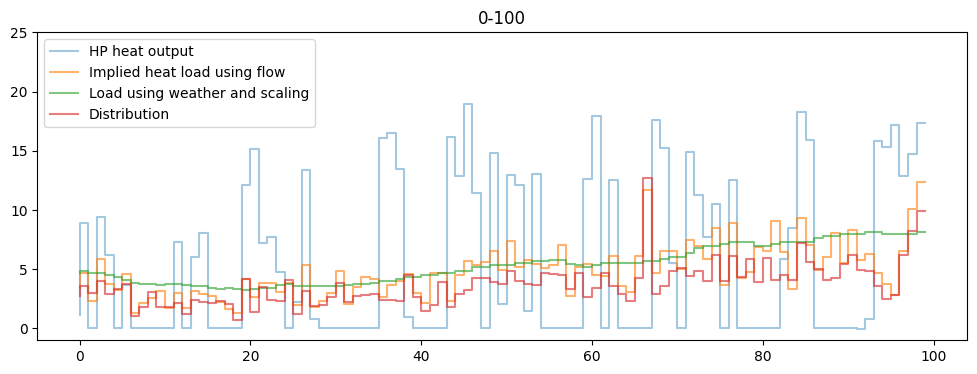

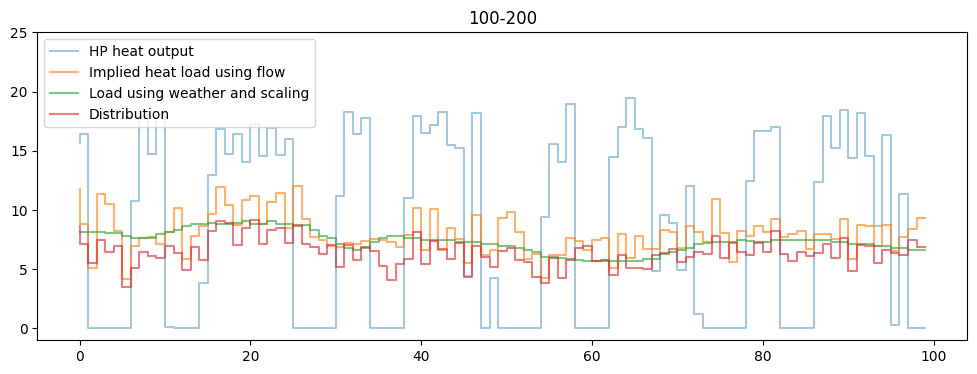

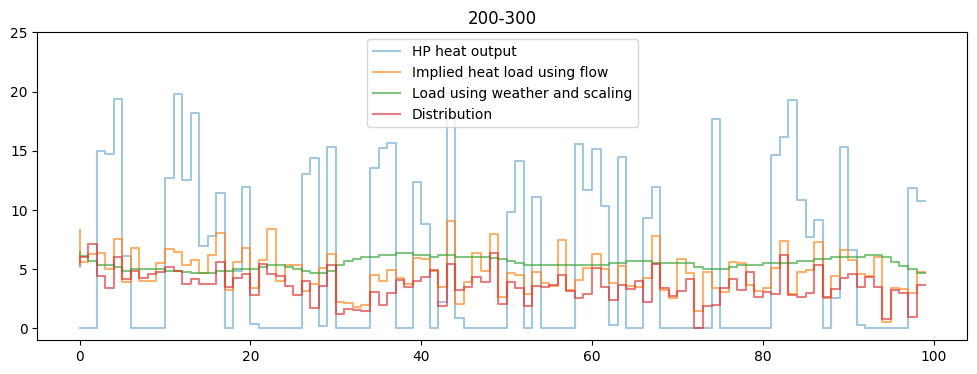

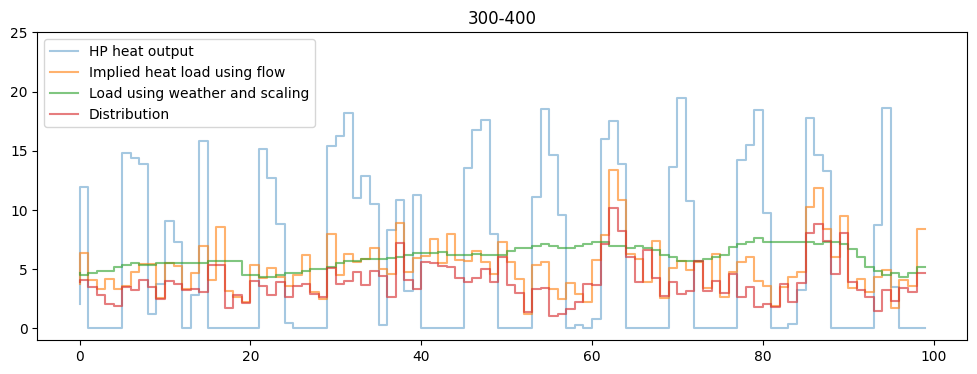

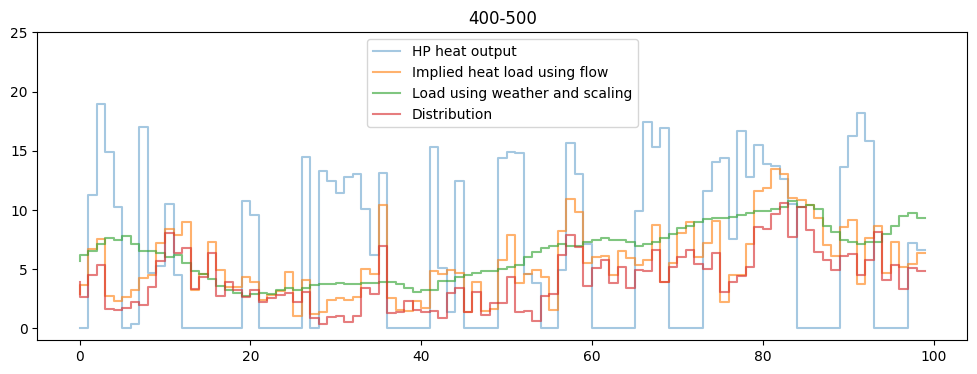

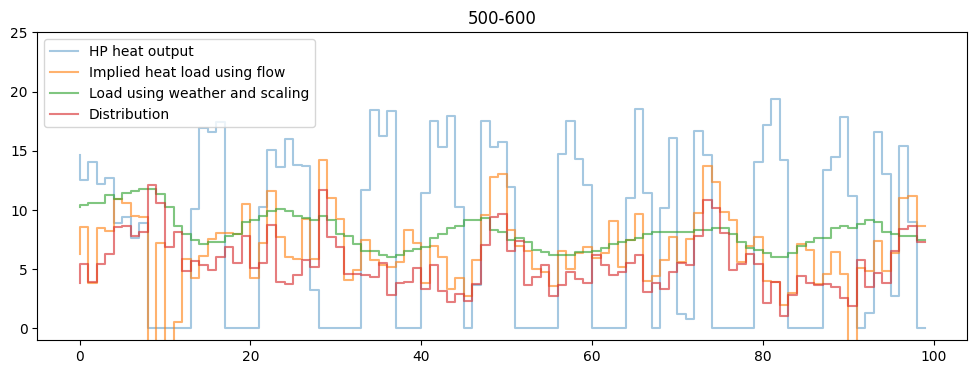

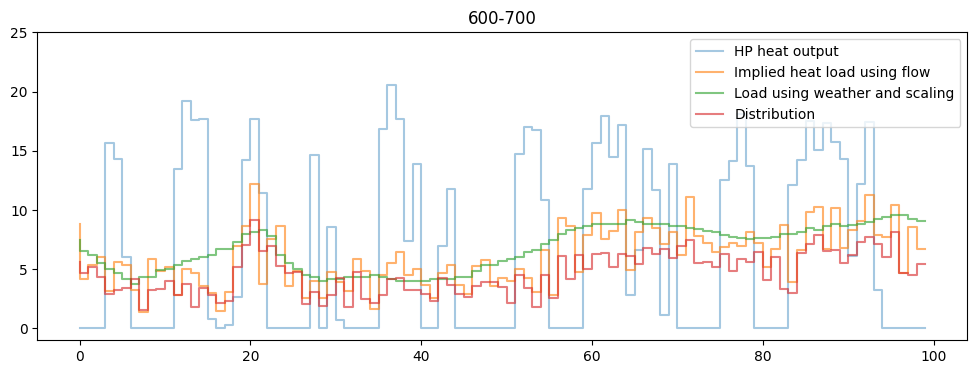

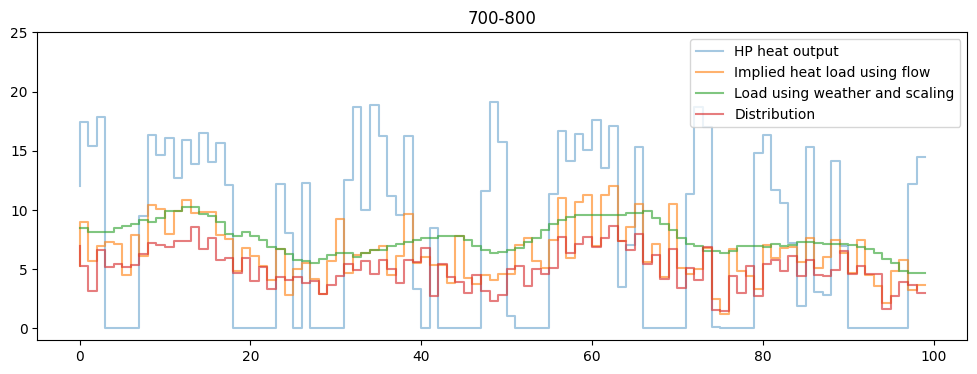

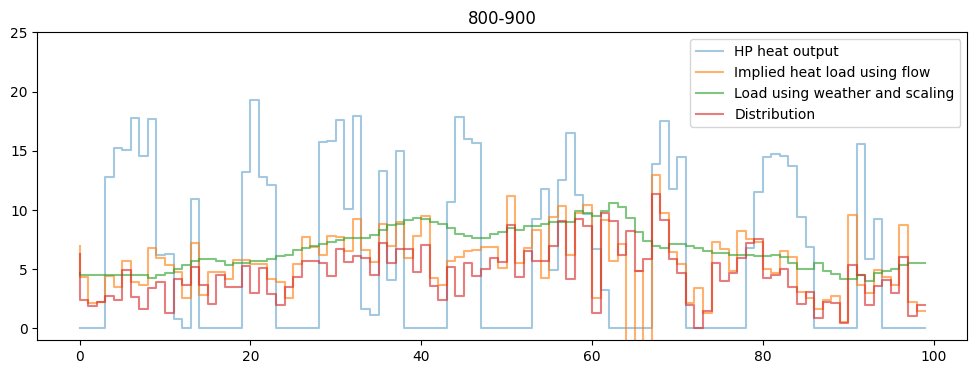

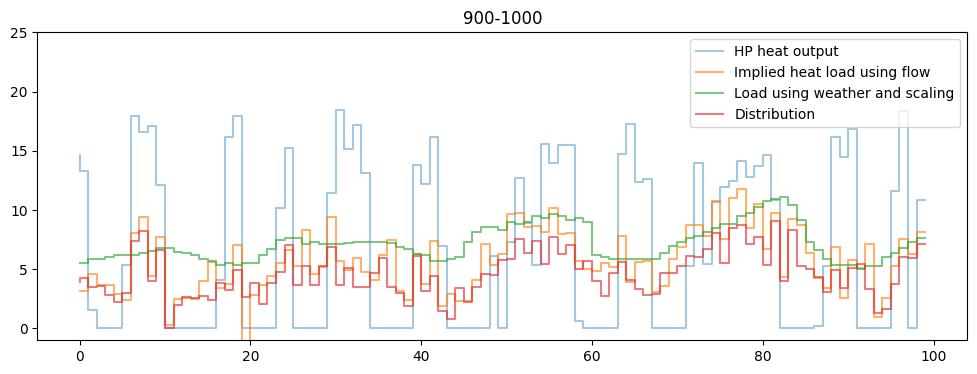

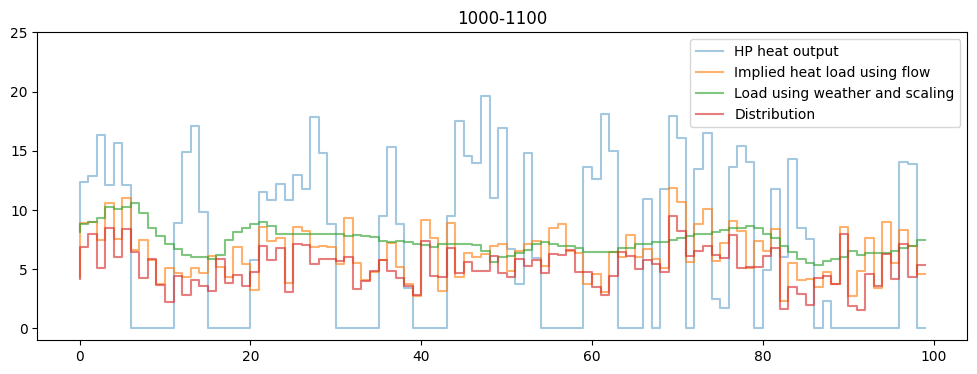

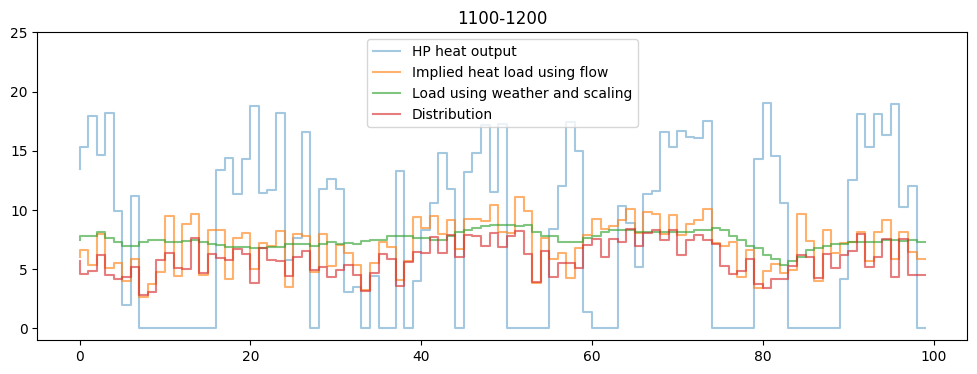

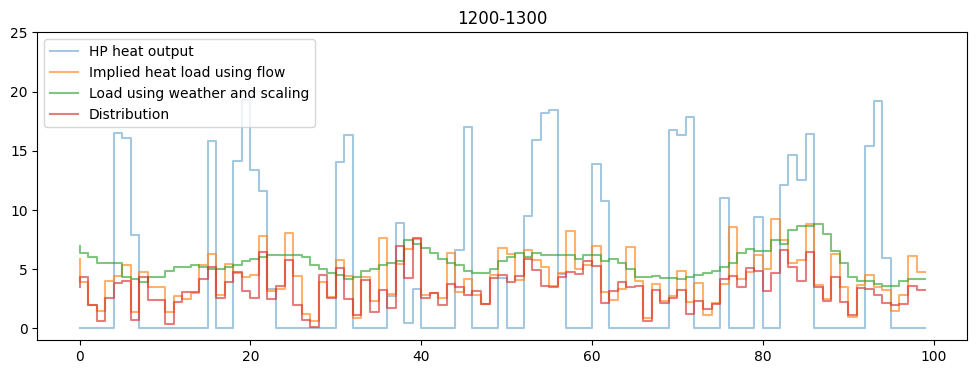

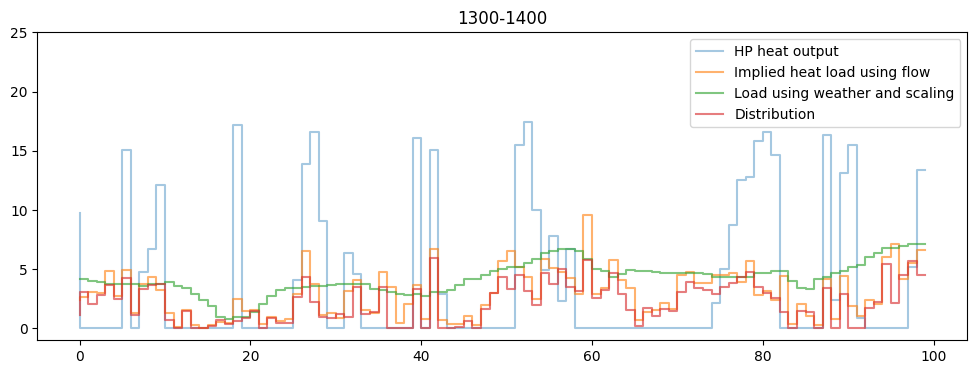

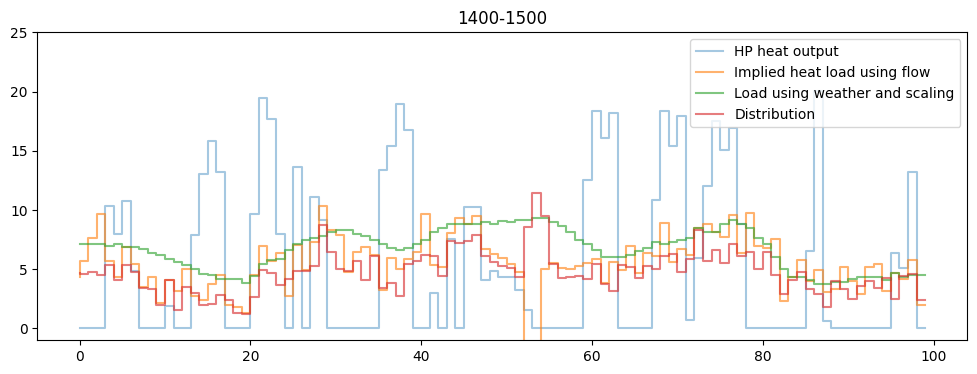

In [2]:
# Take the dataframe between two of those rows
df_same_start_and_end_state = df[:2512-1]

# Add weather data
weather_and_prices_df = pd.read_csv('simulation_data.csv')
final_df = pd.merge(df_same_start_and_end_state, weather_and_prices_df, on='hour_start_s', how='inner')
final_df = final_df[['hour_start', 'hp_kwh_th', 'implied_heat_load', 'implied_heat_load2', 'dist_kwh', 'oat_f', 'ws_mph']]
display(final_df)
final_df.dropna(inplace=True)

# Calculate load based on weather
SCADA_ALPHA=9.3
SCADA_BETA=-0.17
SCADA_GAMMA=0.0015
final_df['weather_load'] = SCADA_ALPHA + SCADA_BETA * final_df['oat_f'] + SCADA_GAMMA * final_df['ws_mph']

# Prints
total_hp_heat_out = round(sum(final_df['hp_kwh_th']),3)
print(f"HP: {total_hp_heat_out}")
total_implied_heat_load = round(sum(final_df['implied_heat_load']),3)
print(f"Implied: {total_implied_heat_load}")
total_weather_load = round(sum(final_df['weather_load']),3)
print(f"Weather and parameters: {total_weather_load}")

# Scale weather based load
scaling_factor = total_weather_load/total_hp_heat_out
final_df['weather_load_scaled'] = final_df['weather_load'] / scaling_factor
total_weather_load_scaled = round(sum(final_df['weather_load_scaled']),3)
print(f"Weather and parameters, scaled: {total_weather_load_scaled}")
print(f"Alpha: {SCADA_ALPHA} -> {round(SCADA_ALPHA/scaling_factor,2)}")
print(f"Beta: {SCADA_BETA} -> {round(SCADA_BETA/scaling_factor,2)}")
print(f"Alpha: {SCADA_GAMMA} -> {round(SCADA_GAMMA/scaling_factor,5)}")

for i in range(15):
    final_df_cropped = final_df[i*100:(i+1)*100]
    plt.figure(figsize=(12,4))
    plt.step(range(len(final_df_cropped)), final_df_cropped['hp_kwh_th'], label='HP heat output', alpha=0.4)
    plt.step(range(len(final_df_cropped)), final_df_cropped['implied_heat_load'], label='Implied heat load using flow', alpha=0.6)
    # plt.step(range(len(final_df_cropped)), final_df_cropped['implied_heat_load2'], label='Implied heat load using tank temps', alpha=0.6, color='tab:orange', linestyle='--')
    # plt.step(range(len(final_df_cropped)), final_df_cropped['weather_load_scaled'], label='Load using weather and scaling', alpha=0.6, color='tab:green')
    plt.step(range(len(final_df_cropped)), final_df_cropped['dist_kwh'], label='Distribution', alpha=0.6, color='tab:red')
    plt.title(f'{i*100}-{(i+1)*100}')
    plt.legend()
    plt.ylim([-1,25])
    plt.show()